In [1]:
import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from causallib.estimation import IPW

In [2]:
# 导入数据
def load_data_from_file(filename):
    with open(filename, 'rb') as handle:
        return pickle.load(handle)

# # 使用函数加载数据
# filename = "data/real_data_norm2.txt"  # 更改为您的文件名
# data = load_data_from_file(filename)
# print(list(data.keys()))

In [38]:
from causallib.datasets import load_nhefs

sample_data = load_nhefs()

In [62]:
learner = LogisticRegression(solver="liblinear")
ipw = IPW(learner)
ipw.fit(sample_data.X, sample_data.a)

IPW(clip_max=None, clip_min=None, use_stabilized=False, verbose=False,
    learner=LogisticRegression(solver='liblinear'))

In [64]:
outcomes = ipw.estimate_population_outcome(sample_data.X, sample_data.a, sample_data.y)

In [70]:
sample_data.X

,age,race,sex,smokeintensity,smokeyrs,wt71,active_1,active_2,education_2,education_3,education_4,education_5,exercise_1,exercise_2,age^2,wt71^2,smokeintensity^2,smokeyrs^2
0,42,1,0,30,29,79.04,0,0,0,0,0,0,0,1,1764,6247.3216,900,841
1,36,0,0,20,24,58.63,0,0,1,0,0,0,0,0,1296,3437.4769,400,576
2,56,1,1,20,26,56.81,0,0,1,0,0,0,0,1,3136,3227.3761,400,676
3,68,1,0,3,53,59.42,1,0,0,0,0,0,0,1,4624,3530.7364,9,2809
4,40,0,0,20,19,87.09,1,0,1,0,0,0,1,0,1600,7584.6681,400,361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1623,47,0,1,20,31,84.94,0,0,0,0,0,0,0,0,2209,7214.8036,400,961
1624,45,0,0,40,29,63.05,0,0,0,0,0,0,0,0,2025,3975.3025,1600,841
1625,47,0,1,20,31,57.72,0,0,0,0,0,0,0,0,2209,3331.5984,400,961
1627,68,0,0,15,46,52.39,1,0,0,0,0,0,1,0,4624,2744.7121,225,2116


In [66]:
TREAT['conformity']

0         3
1         2
2         2
3         3
4         2
         ..
754995    3
754996    3
754997    3
754998    3
754999    3
Name: conformity, Length: 755000, dtype: int64

In [56]:
X.shape

(755000, 17)

## 统计方法尝试

In [4]:
filename = "data/sample5000_for_predict_logdiscrete.txt"
pred_data = load_data_from_file(filename)

In [6]:
print(pred_data['covariates'].shape)

(5000, 151, 14)


In [5]:
# 构建变量
# covariate_cols = ['gender','age','income3','weekday','sprtransp','spring','precip', 'voluntary']
# treatment_cols = ['conformity','restrict','open']
# outcome_col = 'move_distance'
covariate_cols = ['gender','age','income3','weekday_0','weekday_1','weekday_2','weekday_3','weekday_4', 'weekday_5', 'weekday_6',
                  'sprtransp','spring','precip', 'voluntary']
treatment_cols = ['conformity_label0','conformity_label1','conformity_label2','conformity_label3','conformity_label4','restrict','open']
outcome_col = 'move_distance'

X = pd.DataFrame(pred_data['covariates'].reshape(-1,len(covariate_cols)), columns=covariate_cols)
TREAT = pd.DataFrame(pred_data['treatments'].reshape(-1,len(treatment_cols)), columns=treatment_cols)
X = pd.concat([X, TREAT[['restrict','open']]], axis=1)
Y = pd.DataFrame(pred_data['outcomes'].reshape(-1), columns=[outcome_col])
#W = pd.DataFrame(iptw.reshape(-1), columns=['iptw'])

ts = np.tile(np.arange(1, pred_data['outcomes'].shape[1]+1), pred_data['outcomes'].shape[0])
X['t']=ts
TREAT['t']=ts
Y['t']=ts
# ts = np.tile(np.arange(1, 151), 4005)
# W['t']=ts

In [6]:
mapping_dict = {
    tuple([1, 0, 0, 0, 0]): 0,
    tuple([1, 1, 0, 0, 0]): 1,
    tuple([1, 1, 1, 0, 0]): 2,
    tuple([1, 1, 1, 1, 0]): 3,
    tuple([1, 1, 1, 1, 1]): 4
}

# 应用映射
labeled_data = np.zeros(len(TREAT), dtype=int)  # 初始化一个新的数组
labels = TREAT[['conformity_label0','conformity_label1','conformity_label2','conformity_label3','conformity_label4']].values
for i in range(labels.shape[0]):
    labeled_data[i] = mapping_dict[tuple(labels[i])]

TREAT['conformity'] = labeled_data

In [32]:
X.head()

,gender,age,income3,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,sprtransp,spring,precip,voluntary,restrict,open,t
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5


In [25]:
from sklearn.linear_model import LogisticRegression
from causallib.estimation import IPW

# 计算每个时间点的处置效应
#results = np.zeros([pred_data['outcomes'].shape[1],5])
results = np.full((pred_data['outcomes'].shape[1],5), np.nan)
learner = LogisticRegression(solver="liblinear")
for t in range(1,pred_data['outcomes'].shape[1]+1):
    print(t)
    x = X[X['t']==t].reset_index(drop=True)
    x = x.drop('t',axis=1)
    a = TREAT[TREAT['t']==t].reset_index(drop=True)
    y = Y[Y['t']==t].reset_index(drop=True)
    #w = W[W['t']==t].reset_index(drop=True)
    
    ipw = IPW(learner)
    ipw = ipw.fit(x, a['conformity'])
    outcomes = ipw.estimate_population_outcome(x, a['conformity'], y['move_distance'])
    #print(len(outcomes))
    for i in outcomes.index:
        results[t-1,i] = outcomes[i]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151


In [33]:
samples = pred_data['outcomes'].shape[0]
timesteps = pred_data['outcomes'].shape[1]
# 按周汇总数据
# 创建一个日期范围
date_range = pd.date_range(start="2020-01-01", periods=timesteps)

# 为每个日期指定其所在的周
weeks = date_range.week

# 转换数据为长格式
df = pd.DataFrame({
    'week': weeks
})
df[['conformity_label0','conformity_label1','conformity_label2','conformity_label3','conformity_label4']] = results

# 根据标签和所在周进行分组，并计算均值
week_results = df.groupby('week').mean().values.T

/tmp/ipykernel_5368/2965448514.py:8: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  weeks = date_range.week


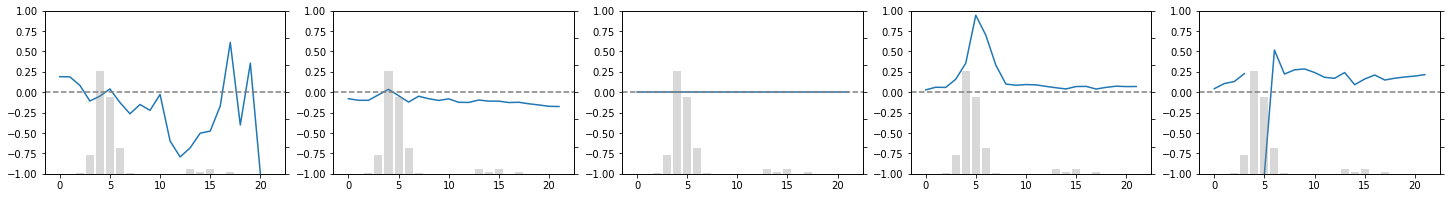

In [40]:
fig, ax = plt.subplots(1,5, figsize=(25,3))
for label in range(5):
    crd = (week_results[label,]-week_results[2,:])/week_results[2,:]
    ax[label].plot(crd)
    ax[label].axhline(0, color='grey', linestyle='--')  # 添加y=0的线
    ax[label].set_ylim([-1,1])
    
    # 创建共享x轴的第二y轴
    ax2 = ax[label].twinx()
    # 在第二y轴上绘制案例数据
    ax2.bar(np.arange(len(case_in_week)), case_in_week, color='grey', alpha=0.3)
    ax2.set_ylim([0, 300])  # 设置第二y轴的范围，你可以根据需要调整
    ax2.set_yticklabels([])
    #ax2.set_ylabel('Case')

In [18]:
learner = LogisticRegression(solver="liblinear")
ipw = IPW(learner)
COVARIATE = X.drop('t',axis=1)
ipw.fit(COVARIATE, TREAT['conformity'])
outcomes = ipw.estimate_population_outcome(COVARIATE, TREAT['conformity'], Y['move_distance'])
outcomes
# ate = ipw.estimate_population_outcome(x, a['conformity'], y['move_distance'], w=w['iptw'])
# #effect =  ipw.estimate_effect(ate[1], ate[0], effect_types=["ratio"])
# ATE.append(ate)

0    4.838525
1    5.091408
2    5.679151
3    6.470186
4    6.546537
dtype: float64

In [24]:
for i in outcomes.index:
    print(i)
    print(outcomes[i])

0
4.838524930288818
1
5.0914083984334075
2
5.6791513571217935
3
6.470185942616452
4
6.546537228847279


In [11]:
ipw.estimate_effect(outcomes[1], outcomes[0], effect_types=["diff"])

diff    0.252883
dtype: float64

In [12]:
outcomes[1]-outcomes[0]

0.2528834681445895

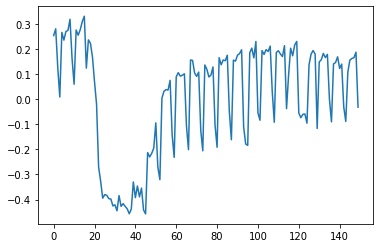

In [124]:
mean_ate = []
for ate in ATE:
    mean_ate.append(ate.mean())
plt.plot(np.arange(len(mean_ate)),mean_ate)

In [122]:
# 政策效应如何？
ipw = IPW(LogisticRegression())

restrict_potential_outcomes = ipw.estimate_population_outcome(_, TREAT['restrict'].loc[:4005*150-1], Y['move_distance'].loc[:4005*150-1], w=W['iptw'])
restrict_effect =  ipw.estimate_effect(restrict_potential_outcomes[1], restrict_potential_outcomes[0], effect_types=["diff"])
print(restrict_effect)

open_potential_outcomes = ipw.estimate_population_outcome(_, TREAT['open'].loc[:4005*150-1], Y['move_distance'].loc[:4005*150-1], w=W['iptw'])
open_effect =  ipw.estimate_effect(open_potential_outcomes[1], open_potential_outcomes[0], effect_types=["diff"])
print(open_effect)

diff   -0.454253
dtype: float64
diff    0.196121
dtype: float64


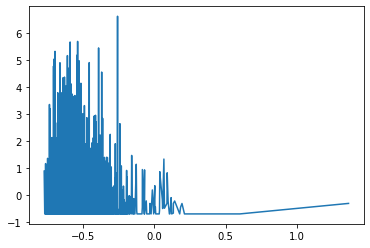

In [99]:
plt.plot(ATE[52])

In [163]:
observation = pd.DataFrame({'Y':Y['move_distance'].loc[:4005*150-1], 'A':TREAT['conformity'].loc[:4005*150-1], 'weight':W['iptw']})
observation.isnull().sum()

Y         0
A         0
weight    0
dtype: int64

In [165]:
observation['weight'] = observation['weight'].apply(lambda x: 0 if x<0 else x)
observation.head()

,Y,A,weight
0,-0.690954,-0.314151,1.000000
1,-0.291751,-0.471655,0.000000
2,2.390220,-0.329599,0.736089
3,1.138759,-0.485213,0.794778
4,-0.690954,-0.245341,0.896729


In [166]:
MSM_model = smf.wls(formula='Y ~ A', data=observation, weights=np.array(observation['weight'], dtype=np.float64)).fit()
#model = smf.ols(formula='Y ~ A', data=observation).fit()
print(MSM_model.summary())

                            WLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.016
Model:                            WLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     9805.
Date:                Tue, 17 Oct 2023   Prob (F-statistic):               0.00
Time:                        19:37:03   Log-Likelihood:                   -inf
No. Observations:              600750   AIC:                               inf
Df Residuals:                  600748   BIC:                               inf
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0022      0.001      1.727      0.0

/root/miniconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:807: RuntimeWarning: divide by zero encountered in log
  llf += 0.5 * np.sum(np.log(self.weights))


In [147]:
np.array(observation['weight'], dtype=np.float64)

array([ 1.        , -0.29527194,  0.73608872, ...,  0.99880715,
        0.99877698,  0.99878318])

In [149]:
df_observed['IPW'].min()

0.0

## 机器学习预测（离散化变量）

In [9]:
# 使用函数加载数据
filename = "results/real_data_results3/sample_10000_logdiscrete_control_gamma_0.6_prediction_log.txt"
data = load_data_from_file(filename)
for key in list(data.keys()):
    print(key)
    print(data[key].shape)

means
(5000, 151, 1)
upper_bounds
(5000, 151, 1)
lower_bounds
(5000, 151, 1)
labels
(5000, 151, 5)
observations
(5000, 151, 1)


In [114]:
unique_values, counts = np.unique(data['labels'], return_counts=True)

# 将结果打印为类似于 dataframe 的 value_counts 的格式
for value, count in zip(unique_values, counts):
    print(f"{value}: {count}")

# 获取 ndarray 中的唯一值并进行排序
unique_values = np.sort(np.unique(data['labels']))
# 创建一个替换的映射
value_to_label = {value: label for label, value in enumerate(unique_values)}

# 使用 numpy 的 vectorize 函数应用映射
vectorized_func = np.vectorize(value_to_label.get)
labeled_data = vectorized_func(data['labels'])
labeled_data = labeled_data[:,:-1]

print(labeled_data)
print(labeled_data.shape)

-0.5291113660271073: 662601
0.8847027923807472: 170977
2.298516950788602: 50810
3.712331109196456: 19980
5.12614526760431: 1632
[[0 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [0 0 1 ... 0 0 1]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]
 [0 1 1 ... 2 2 2]]
(6000, 150)


In [4]:
# 创建映射字典
mapping_dict = {
    tuple([1, 0, 0, 0, 0]): 0,
    tuple([1, 1, 0, 0, 0]): 1,
    tuple([1, 1, 1, 0, 0]): 2,
    tuple([1, 1, 1, 1, 0]): 3,
    tuple([1, 1, 1, 1, 1]): 4
}

# 应用映射
labeled_data = np.zeros((data['labels'].shape[0], data['labels'].shape[1]), dtype=int)  # 初始化一个新的数组
for i in range(data['labels'].shape[0]):
    for j in range(data['labels'].shape[1]):
        labeled_data[i, j] = mapping_dict[tuple(data['labels'][i, j])]

labeled_data = labeled_data[:,:-1]
print(labeled_data.shape)

(5000, 150)


In [5]:
outcomes = data['means'].reshape(data['means'].shape[0], data['means'].shape[1])
uppers = data['upper_bounds'].reshape(data['means'].shape[0], data['means'].shape[1])
lowers = data['lower_bounds'].reshape(data['means'].shape[0], data['means'].shape[1])
observations = data['observations'].reshape(data['observations'].shape[0], data['observations'].shape[1])[:,:-1]
print(outcomes.shape)
print(observations.shape)

(5000, 150)
(5000, 150)


In [6]:
# 按从众类别求均值
# 初始化结果矩阵
label_counts = 5
samples = outcomes.shape[0]
timesteps = outcomes.shape[1]
results = np.zeros((label_counts, timesteps))

for t in range(timesteps):  # 遍历每个时间点
    for label in range(label_counts):  # 遍历每个标签
        mask = (labeled_data[:, t] == label)  # 创建一个掩码，表示哪些样本在当前时间点有此标签
        if np.sum(mask) > 0:  # 如果在当前时间点有任何样本具有此标签
            results[label, t] = np.mean(outcomes[mask, t])  # 计算均值并保存到结果矩阵中

In [7]:
# 按周汇总数据
# 创建一个日期范围
date_range = pd.date_range(start="2020-01-01", periods=timesteps)

# 为每个日期指定其所在的周
weeks = date_range.week

# 转换数据为长格式
df = pd.DataFrame({
    'week': np.tile(weeks, samples),
    'label': labeled_data.ravel(),
    'outcome': outcomes.ravel(),
    'upper':uppers.ravel(),
    'lower':lowers.ravel(),
    'observation':observations.ravel()
})

# 根据标签和所在周进行分组，并计算均值
results = df.groupby(['label', 'week']).outcome.mean().unstack()
upp_results = df.groupby(['label', 'week']).upper.mean().unstack()
low_results = df.groupby(['label', 'week']).lower.mean().unstack()
results = results.values
upp_results = upp_results.values
low_results = low_results.values

print(results)
print(results.shape)

/tmp/ipykernel_780/230018938.py:6: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  weeks = date_range.week


[[6.45949221 6.77933178 6.85017323 4.21135749 2.93837296 3.03380881
  3.67857545 4.78457398 5.66477579 5.69576814 5.8273334  5.73639475
  5.87418849 6.10658293 6.34447211 5.9899711  6.02813335 6.29999248
  6.32234988 6.41561089 6.36024846        nan]
 [6.67424562 6.62314608 6.71996167 4.08736408 2.94816895 3.04434679
  3.81042037 5.3235577  6.0925513  5.94369544 6.08111788 6.10282447
  6.17074708 6.03601933 6.08209337 5.99225846 6.0391486  5.98368438
  6.15249167 6.06340064 5.89673624 5.64199797]
 [6.92154656 6.77783406 6.79571857 4.41533721 3.43960834 3.95395012
  4.58231602 5.95835868 6.28028862 6.36478363 6.40867118 6.40285568
  6.36415624 6.19721367 6.47907523 6.4027986  6.39683118 6.20521839
  6.40825167 6.32141532 6.18039248 5.94256179]
 [7.15192934 7.09329314 7.06473006 5.69030627 4.10272588 4.96185589
  5.39799129 6.01382569 6.64389816 6.76399368 6.82405074 6.86253499
  6.75328422 6.46506364 6.77879099 6.84651573 6.86860076 6.46554071
  6.65531752 6.66461451 6.59449683 6.420252

In [47]:
results[:,-1]

array([0., 0., 0., 0., 0.])

In [8]:
# 导入病例数
case = pd.read_csv('data/case_series.csv')
case = case[case['date']>=20200101].reset_index(drop=True)
case = case[['date','voluntary']]
case['time'] = np.arange(len(case))
case['week'] = pd.to_datetime(case['date'].astype(str), format="%Y%m%d").dt.isocalendar().week
case.head()

,date,voluntary,time,week
0,20200101,0,0,1
1,20200102,0,1,1
2,20200103,0,2,1
3,20200104,0,3,1
4,20200105,0,4,1


In [9]:
case_in_week = case.groupby('week')['voluntary'].sum().values
case_in_week

array([  0,   0,   1,  35, 190, 142,  47,   2,   0,   0,   0,   0,   0,
         9,   4,   9,   0,   4,   0,   0,   0,   0])

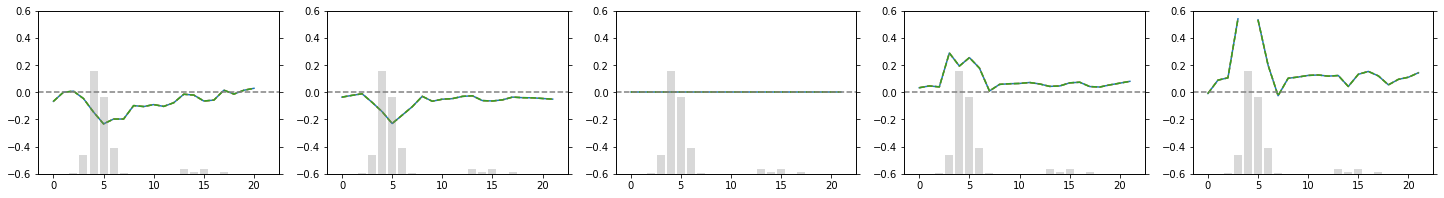

In [10]:
fig, ax = plt.subplots(1,5, figsize=(25,3))
for label in range(label_counts):
    crd = (results[label,]-results[2,:])/results[2,:]
    upp_crd = (upp_results[label,]-results[2,:])/results[2,:]
    low_crd = (low_results[label,]-results[2,:])/results[2,:]
    ax[label].plot(crd)
    ax[label].plot(upp_crd, linestyle='--')
    ax[label].plot(low_crd, linestyle='--')
    ax[label].axhline(0, color='grey', linestyle='--')  # 添加y=0的线
    ax[label].set_ylim([-0.6,0.6])
    
    # 创建共享x轴的第二y轴
    ax2 = ax[label].twinx()
    # 在第二y轴上绘制案例数据
    ax2.bar(np.arange(len(case_in_week)), case_in_week, color='grey', alpha=0.3)
    ax2.set_ylim([0, 300])  # 设置第二y轴的范围，你可以根据需要调整
    ax2.set_yticklabels([])
    #ax2.set_ylabel('Case')

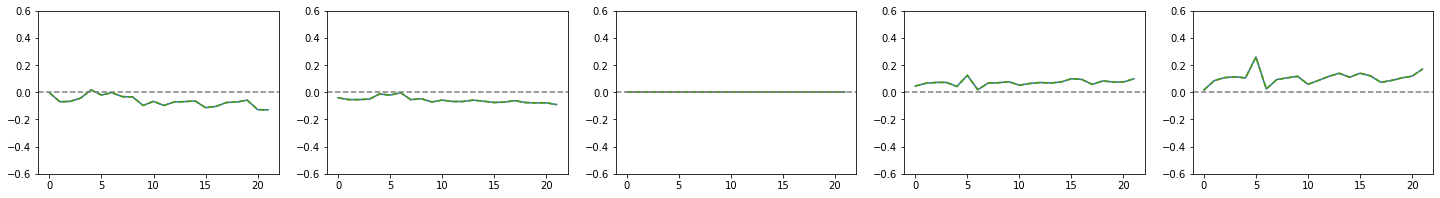

In [8]:
# 2019年对照组
fig, ax = plt.subplots(1,5, figsize=(25,3))
for label in range(label_counts):
    crd = (results[label,]-results[2,:])/results[2,:]
    upp_crd = (upp_results[label,]-results[2,:])/results[2,:]
    low_crd = (low_results[label,]-results[2,:])/results[2,:]
    ax[label].plot(crd)
    ax[label].plot(upp_crd, linestyle='--')
    ax[label].plot(low_crd, linestyle='--')
    ax[label].axhline(0, color='grey', linestyle='--')  # 添加y=0的线
    ax[label].set_ylim([-0.6,0.6])

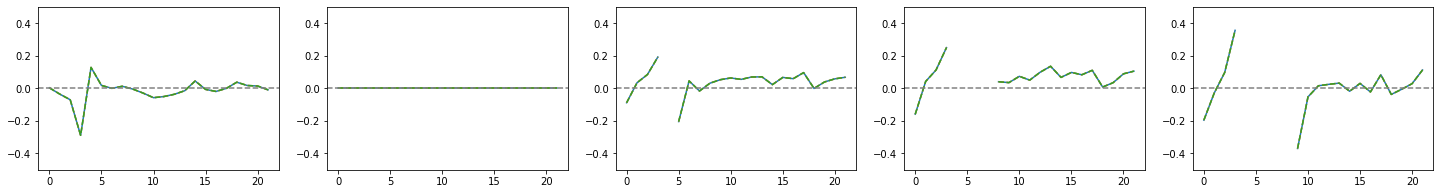

In [125]:
fig, ax = plt.subplots(1,5, figsize=(25,3))
for label in range(label_counts):
    crd = (results[label,]-results[1,:])/results[1,:]
    upp_crd = (upp_results[label,]-results[1,:])/results[1,:]
    low_crd = (low_results[label,]-results[1,:])/results[1,:]
    ax[label].plot(crd)
    ax[label].plot(upp_crd, linestyle='--')
    ax[label].plot(low_crd, linestyle='--')
    ax[label].axhline(0, color='grey', linestyle='--')  # 添加y=0的线
    ax[label].set_ylim([-0.5,0.5])

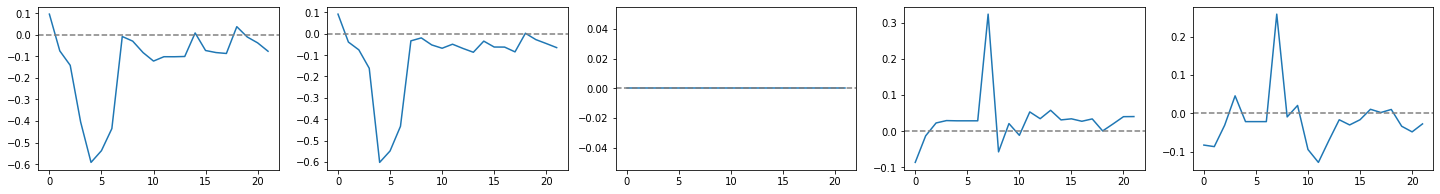

In [92]:
# 补全缺失值再显示一次
for i in range(results.shape[0]):
    row_mean = np.nanmean(results[i, :])
    results[i, np.isnan(results[i, :])] = row_mean

fig, ax = plt.subplots(1,5, figsize=(25,3))
for label in range(label_counts):
    crd = (results[label,]-results[2,:])/results[2,:]
    ax[label].plot(crd)
    ax[label].axhline(0, color='grey', linestyle='--')  # 添加y=0的线

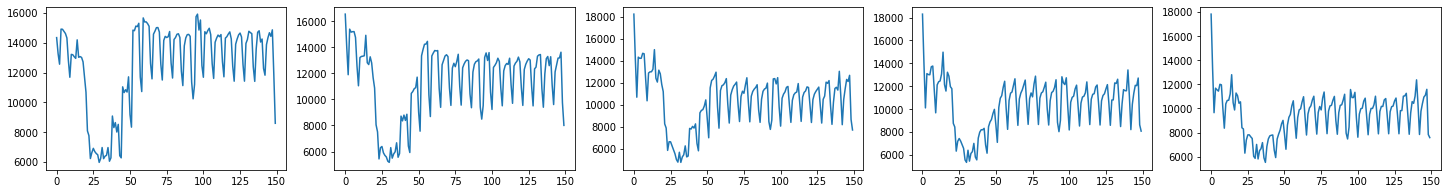

In [110]:
# 修改conformity取值后预测（每个class都有5000个样本）
# fig, ax = plt.subplots(1,5, figsize=(25,3))
df = pd.DataFrame({
    'week': weeks
})
for label in range(label_counts):
    filename = "results/real_data_results3/sample_10000_discrete_control_gamma_0.6_prediction" + str(label) + ".txt"
    data = load_data_from_file(filename)
    outcomes = data['means'].reshape(data['means'].shape[0], data['means'].shape[1])
    df['results'+str(label)] = np.mean(outcomes, axis=0)
    # ax[label].plot(np.mean(outcomes, axis=0))
    
results = df.groupby(['week']).mean()
results = results.values.T
print(results)
print(results.shape)

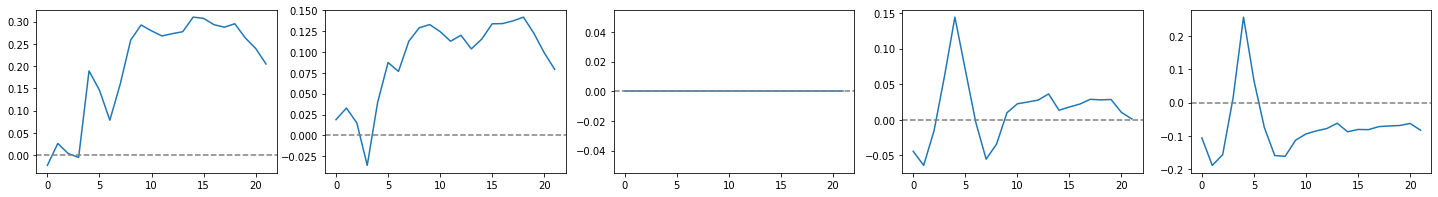

In [112]:
fig, ax = plt.subplots(1,5, figsize=(25,3))
for label in range(label_counts):
    crd = (results[label,]-results[2,:])/results[2,:]
    ax[label].plot(crd)
    ax[label].axhline(0, color='grey', linestyle='--')  # 添加y=0的线

## Dynamic Treatment Effects

In [61]:
# 导入iptw权重
iptw = np.load('results/rmsn_sample_10000_logdiscrete_control_gamma_0.6_use_confounders_True/propensity_scores_w_all.npy')
print(iptw.shape)

(5000, 150, 1)


In [62]:
df['iptw'] = iptw.ravel()
df.head()

,week,label,outcome,upper,lower,observation,iptw
0,1,3,6.886320,6.886320,6.886320,0.000000,1.000000
1,1,2,6.534663,6.534663,6.534663,0.000000,0.369808
2,1,2,6.331280,6.331280,6.331280,9.550876,0.601732
3,1,3,7.017721,7.017721,7.017721,11.446786,3.311974
4,1,2,6.635595,6.635595,6.635595,11.115592,0.553101


In [63]:
print(df['iptw'].isnull().sum())

0


In [69]:
# 计算动态处置效应
# 计算加权平均值的函数
def weighted_avg(group, avg_name, weight_name):
    d = group[avg_name]
    w = 1/group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return np.nan

# 使用groupby按照'week'和'label'分组，并计算加权平均值
weighted_averages = df.groupby(['week', 'label']).apply(weighted_avg, 'observation', 'iptw')

# 重新排列结果，使其变成(num_labels, num_weeks)的二维结构
results = weighted_averages.unstack()

# 如果你想要得到一个numpy array而不是pandas DataFrame
results = results.values.T
print(results)
print(results.shape)

[[8.14668851e+00 4.27172039e+00 9.57152818e+00 1.29473809e-01
  4.89111402e+00 3.31332116e+00 6.57198936e+00 5.89150892e+00
  2.08782018e+00 1.41039250e+00 4.44300952e+00 1.40271531e+00
  1.18227070e+00 3.94648480e-04 1.47454706e-03 2.11647556e+00
  2.25751280e-01 9.04040924e+00 7.30234811e+00 9.07132896e+00
  0.00000000e+00            nan]
 [6.58047751e+00 7.34369704e+00 7.80011797e+00 4.17432398e+00
  3.33717467e+00 2.97503452e+00 3.71309810e+00 5.55676258e+00
  5.69224080e+00 5.42839847e+00 5.99911495e+00 5.74512088e+00
  5.50711886e+00 4.88172853e+00 6.61084459e+00 6.10034328e+00
  7.79003007e+00 4.74428812e+00 7.16437448e+00 6.10971358e+00
  5.84063982e+00 6.57782987e+00]
 [6.79259377e+00 6.89666874e+00 7.16403428e+00 4.47226741e+00
  3.45521455e+00 3.57754879e+00 4.10317375e+00 5.13083457e+00
  5.67995118e+00 5.63768357e+00 5.69337512e+00 5.70310507e+00
  6.07474067e+00 5.08659111e+00 6.62428336e+00 6.19728357e+00
  7.12825775e+00 5.77679464e+00 6.79947672e+00 6.10178674e+00
  5.

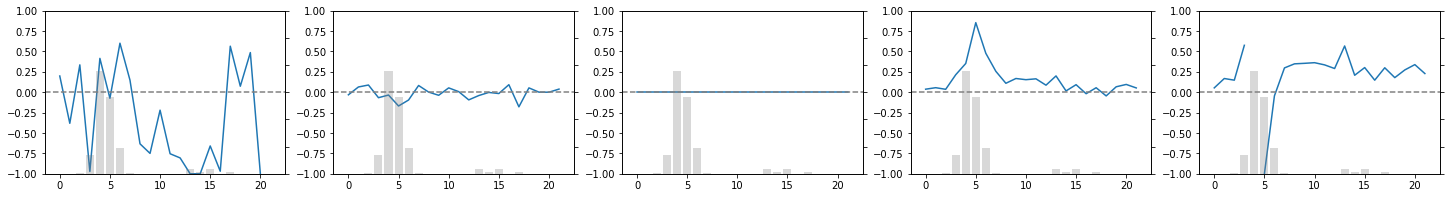

In [70]:
fig, ax = plt.subplots(1,5, figsize=(25,3))
for label in range(label_counts):
    crd = (results[label,]-results[2,:])/results[2,:]
    ax[label].plot(crd)
    ax[label].axhline(0, color='grey', linestyle='--')  # 添加y=0的线
    ax[label].set_ylim([-1,1])
    
    # 创建共享x轴的第二y轴
    ax2 = ax[label].twinx()
    # 在第二y轴上绘制案例数据
    ax2.bar(np.arange(len(case_in_week)), case_in_week, color='grey', alpha=0.3)
    ax2.set_ylim([0, 300])  # 设置第二y轴的范围，你可以根据需要调整
    ax2.set_yticklabels([])
    #ax2.set_ylabel('Case')